# Mass Regression Notebook
In this notebook we will explore the first concepts of how to apply a neural network or deep learning to the 2-D mass plane.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import uproot as ur
import awkward as ak
import atlas_mpl_style as ampl
ampl.use_atlas_style()

print('Numpy version: {}'.format(np.__version__))
print('Uproot version: {}'.format(ur.__version__))
print('Awkward version: {}'.format(ak.__version__))

Numpy version: 1.23.1
Uproot version: 4.3.3
Awkward version: 1.8.0


## Uproot files

In [2]:
rootfile_prefix = '/fast_scratch_1/atlas_images/XhhNTuple/'
rfile = 'user.zhenw.29137978._000001.MiniNTuple.root'

In [3]:
uprooted = ur.open(rootfile_prefix+rfile)
uprooted.keys()

['XhhMiniNtuple;1',
 'cutflow_XhhMiniNtuple;1',
 'cutflow_weighted_XhhMiniNtuple;1',
 'MetaData_EventCount_XhhMiniNtuple;1']

In [4]:
MNTuple = uprooted['XhhMiniNtuple']
# events.arrays(["px1", "py1", "pz1"])
MNTuple.show(name_width=32,
            interpretation_width=30)

name                             | typename                 | interpretation                
---------------------------------+--------------------------+-------------------------------
runNumber                        | int32_t                  | AsDtype('>i4')
eventNumber                      | int64_t                  | AsDtype('>i8')
lumiBlock                        | int32_t                  | AsDtype('>i4')
coreFlags                        | uint32_t                 | AsDtype('>u4')
bcid                             | int32_t                  | AsDtype('>i4')
mcEventNumber                    | int32_t                  | AsDtype('>i4')
mcChannelNumber                  | int32_t                  | AsDtype('>i4')
mcEventWeight                    | float                    | AsDtype('>f4')
NPV                              | int32_t                  | AsDtype('>i4')
actualInteractionsPerCrossing    | float                    | AsDtype('>f4')
averageInteractionsPerCrossing   | float    

## Load Utils

In [5]:
import os
import sys
cwd = os.getcwd()
path_head, path_tail = os.path.split(cwd)
sys.path.append(path_head+'/utils')
from ml_utils import dict_from_tree, DeltaR, tvt_num
from time import perf_counter as cput

## Load Data

In [6]:
branches = ['boosted_nGoodJets', "nboostedJets", "boostedJets_m",
            "boostedJets_pt", "boostedJets_phi", "boostedJets_eta",
           "truth_mHH", 'truthjet_antikt10_pt', 'truthjet_antikt10_eta',
           'truthjet_antikt10_phi', 'truthjet_antikt10_m',
           'boostedJets_numConstituents', 'boostedJets_nChargedParticles',
           'boostedJets_EMFrac', 'boostedJets_Nclusters',
           'boostedJets_NTrimSubjets', 'boostedJets_ungrtrk500']
np_branches = ['eventNumber']

In [7]:
t0 = cput()
hh4b_dict = dict_from_tree(MNTuple, branches, np_branches)
t1 = cput()
method_1_time = t1 - t0
print('Time to load arrays: {:8.4f} (s)'.format(method_1_time))

nEvents = len(hh4b_dict['eventNumber'])
print('{} Events'.format(nEvents))

Time to load arrays:   1.4723 (s)
339978 Events


In [8]:
gt_twoJets = np.zeros(nEvents, dtype=bool)
t0 = cput()
for i in range(nEvents):
    boostedJets_pt = ak.to_numpy(hh4b_dict['boostedJets_pt'][i])
    
    if len(boostedJets_pt) >=2:
        gt_twoJets[i] = True

n2jets = np.count_nonzero(gt_twoJets)
print('Number of events with > 2 jets'.format(n2jets))
t1 = cput()
print('time: {:8.2f}'.format(t1 - t0))

Number of events with > 2 jets
time:    29.09


# Fill arrays with inputs

In [9]:
list_indices = np.arange(nEvents)
# evt_idx = np.full(shape=(n2jets,), fill_value=-1)
evt_idx = np.ndarray.copy(list_indices[gt_twoJets])

# for jk in range(20):
#     evt = evt_idx[jk]
#     nboosted = len(ak.to_numpy(hh4b_dict['boostedJets_pt'][evt]))
#     print('Event with matched jets: {}'.format(evt_idx[jk]))
#     print('Number of boosted jets:   {}'.format(nboosted))

In [10]:
t0 = cput()
matched_jets = []
for i, evt in enumerate(evt_idx):
    
    nTruthJets = ak.to_numpy(hh4b_dict['truthjet_antikt10_m'][evt]).shape[0]
    truthJet_coords = np.empty((nTruthJets, 2))
    # this can be vectorized easily (too tired)
    for j in range(nTruthJets):
        truthJet_coords[j,0] = hh4b_dict['truthjet_antikt10_eta'][evt][j]
        truthJet_coords[j,1] = hh4b_dict['truthjet_antikt10_phi'][evt][j]
    
    BoostedJet0_eta = hh4b_dict['boostedJets_eta'][evt][0]
    BoostedJet0_phi = hh4b_dict['boostedJets_phi'][evt][0]
    BoostedJet0_coords = np.array([BoostedJet0_eta, BoostedJet0_phi])
    LeadingJet_DR_arr = DeltaR(truthJet_coords, BoostedJet0_coords)
    # print(LeadingJet_DR_arr)
    LJ_DR = np.min(LeadingJet_DR_arr)
    LJ_DR_idx = np.argmin(LeadingJet_DR_arr)
    
    BoostedJet1_eta = hh4b_dict['boostedJets_eta'][evt][1]
    BoostedJet1_phi = hh4b_dict['boostedJets_phi'][evt][1]
    BoostedJet1_coords = np.array([BoostedJet1_eta, BoostedJet1_phi])
    subLeadingJet_DR_arr = DeltaR(truthJet_coords, BoostedJet1_coords)
    # print(subLeadingJet_DR_arr)
    SLJ_DR = np.min(subLeadingJet_DR_arr)
    SLJ_DR_idx = np.argmin(subLeadingJet_DR_arr)
    
    if SLJ_DR_idx != LJ_DR_idx:
        if LJ_DR < .1 and SLJ_DR < .1:
            matched_jets.append([evt, LJ_DR_idx, SLJ_DR_idx])
    
    # print();print()

t1 = cput()
print('Time to complete jet matching: {:6.3f} (m)'.format((t1 - t0)/60))
print();print()
matched_jets = np.array(matched_jets)

print(matched_jets.shape)

Time to complete jet matching:  1.661 (m)


(94859, 3)


In [11]:
X = np.empty((matched_jets.shape[0],20))
Y = np.empty((matched_jets.shape[0],2))

In [12]:
for i in range(matched_jets.shape[0]):
    arr_slc = matched_jets[i]
    evt = arr_slc[0]
    ld_idx = arr_slc[1]
    sld_idx = arr_slc[2]

    nboosted = len(ak.to_numpy(hh4b_dict['boostedJets_pt'][evt]))
    
    # Leading
    X[i,0] = hh4b_dict['boostedJets_m'][evt][0]
    X[i,1] = hh4b_dict['boostedJets_pt'][evt][0]
    X[i,2] = hh4b_dict['boostedJets_eta'][evt][0]
    X[i,3] = hh4b_dict['boostedJets_phi'][evt][0]
    X[i,4] = hh4b_dict['boostedJets_numConstituents'][evt][0]
    X[i,5] = hh4b_dict['boostedJets_nChargedParticles'][evt][0]
    X[i,6] = hh4b_dict['boostedJets_EMFrac'][evt][0]
    X[i,7] = hh4b_dict['boostedJets_ungrtrk500'][evt][0]
    X[i,8] = hh4b_dict['boostedJets_Nclusters'][evt][0]
    X[i,9] = hh4b_dict['boostedJets_NTrimSubjets'][evt][0]
    
    
    # Sub-Leading
    X[i,10] = hh4b_dict['boostedJets_m'][evt][1]
    X[i,11] = hh4b_dict['boostedJets_pt'][evt][1]
    X[i,12] = hh4b_dict['boostedJets_eta'][evt][1]
    X[i,13] = hh4b_dict['boostedJets_phi'][evt][1]
    X[i,14] = hh4b_dict['boostedJets_numConstituents'][evt][1]
    X[i,15] = hh4b_dict['boostedJets_nChargedParticles'][evt][1]
    X[i,16] = hh4b_dict['boostedJets_EMFrac'][evt][1]
    X[i,17] = hh4b_dict['boostedJets_ungrtrk500'][evt][1]
    X[i,18] = hh4b_dict['boostedJets_Nclusters'][evt][1]
    X[i,19] = hh4b_dict['boostedJets_NTrimSubjets'][evt][1]
    
    # Truth Jet
    ''' in rare circumstances these can be mismatched with reco
    jets so we need to be consistent with this! '''
    Y[i,0] = hh4b_dict['truthjet_antikt10_m'][evt][ld_idx]
    Y[i,1] = hh4b_dict['truthjet_antikt10_m'][evt][sld_idx]

In [13]:
# X = np.random.uniform(low=-1, high=1.0, size=(matched_jets.shape[0],8))
# Y = np.random.uniform(low=-1, high=1.0, size=(matched_jets.shape[0],2))

In [14]:
from ml_mass_regression_models import Dumb_Network, DNN_wDropout, Split_Network
import tensorflow as tf
from tensorflow import keras

import os
os.environ['CUDA_VISIBLE_DEVICES'] = "1"
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

In [15]:
test_model = Dumb_Network(num_features=8)
test_model.compile(loss='mse', optimizer=keras.optimizers.Adam(
    learning_rate=.001))
test_model.summary()

Model: "dum-dum-net"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 8)]               0         
_________________________________________________________________
dense_0 (Dense)              (None, 100)               900       
_________________________________________________________________
activation_0 (Activation)    (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               10100     
_________________________________________________________________
activation_1 (Activation)    (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
activation_2 (Activation)    (None, 100)               

2022-10-04 06:10:37.196036: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2022-10-04 06:10:37.196095: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9672 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:1b:00.0, compute capability: 7.5


In [16]:
# history = test_model.fit(X,
#               Y,
#               epochs=10,
#               batch_size=1000)

## Okay model is learning but we need to normalize inputs of course!

## un-normalized

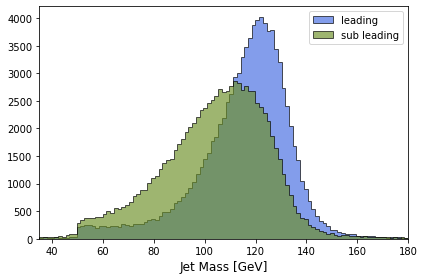

In [17]:
mass_bins = np.linspace(35,180,100,endpoint=True)

plt.hist(X[:,0], bins=mass_bins, label='leading', alpha=.65, color='royalblue',
        edgecolor='black', histtype='stepfilled')
plt.hist(X[:,10], bins=mass_bins, label='sub leading', alpha=.65,
         color='olivedrab', edgecolor='black', histtype='stepfilled')
plt.xlim(np.min(mass_bins), np.max(mass_bins))
plt.xlabel('Jet Mass [GeV]', fontsize=12)
plt.legend()
plt.tight_layout()
# plt.savefig('Plots/Sept22/jetmass_unnormalized.png')
plt.show()

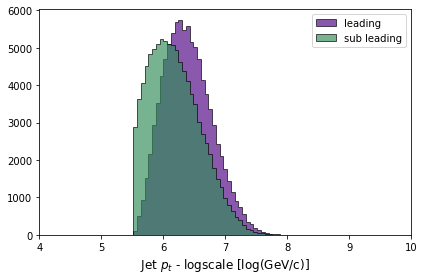

Minimum pt: -999.0000
Maximum pt jet: 3312.10205078125


In [18]:
logPt_bins = np.linspace(4,10,100,endpoint=True)

plt.hist(np.log(X[:,1]), bins=logPt_bins, label='leading', alpha=.65, color='indigo',
        edgecolor='black', histtype='stepfilled')
plt.hist(np.log(X[:,11]), bins=logPt_bins, label='sub leading', alpha=.65,
         color='seagreen', edgecolor='black', histtype='stepfilled')
plt.xlim(4, np.max(logPt_bins))
plt.xlabel('Jet $p_t$ - logscale [log(GeV/c)]', fontsize=12)
plt.legend()
plt.tight_layout()
# plt.savefig('Plots/Sept22/jetpt_unnormalized.png')
plt.show()

print('Minimum pt: {:8.4f}'.format(np.min(X[:,5])))
print('Maximum pt jet: {}'.format(np.max(X[:,1])))

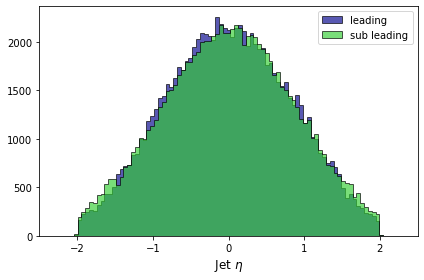

In [19]:
eta_bins = np.linspace(-2.5,2.5,100,endpoint=True)

plt.hist(X[:,2], bins=eta_bins, label='leading', alpha=.65, color='darkblue',
        edgecolor='black', histtype='stepfilled')
plt.hist(X[:,12], bins=eta_bins, label='sub leading', alpha=.65,
         color='limegreen', edgecolor='black', histtype='stepfilled')
plt.xlim(np.min(eta_bins), np.max(eta_bins))
plt.legend()
plt.xlabel('Jet $\eta$', fontsize=12)
plt.tight_layout()
# plt.savefig('Plots/Sept22/jeteta_unnormalized.png')
plt.show()

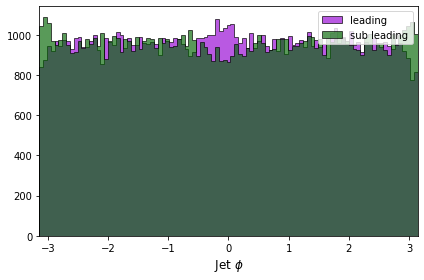

In [20]:
phi_bins = np.linspace(-np.pi,np.pi,100,endpoint=True)

plt.hist(X[:,3], bins=phi_bins, label='leading', alpha=.65, color='darkviolet',
        edgecolor='black', histtype='stepfilled')
plt.hist(X[:,13], bins=phi_bins, label='sub leading', alpha=.65,
         color='darkgreen', edgecolor='black', histtype='stepfilled')
plt.xlim(np.min(phi_bins), np.max(phi_bins))
plt.legend()
plt.xlabel('Jet $\phi$', fontsize=12)
plt.tight_layout()
# plt.savefig('Plots/Sept22/jetphi_unnormalized.png')
plt.show()

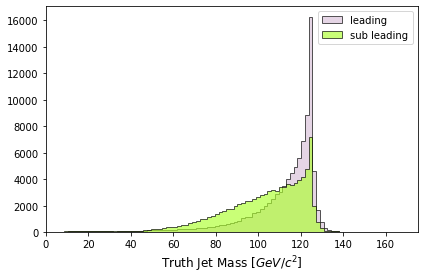

In [21]:
target_bins = np.linspace(0,175,100,endpoint=True)

plt.hist(Y[:,0]/1000, bins=target_bins, label='leading', alpha=.65, color='thistle',
        edgecolor='black', histtype='stepfilled')
plt.hist(Y[:,1]/1000, bins=target_bins, label='sub leading', alpha=.65,
         color='greenyellow', edgecolor='black', histtype='stepfilled')
plt.xlim(np.min(target_bins), np.max(target_bins))
plt.legend()
plt.xlabel('Truth Jet Mass $[GeV/c^2]$', fontsize=12)
plt.tight_layout()
# plt.savefig('Plots/Sept22/truthJetMass_unnormalized.png')
plt.show()

## Normalized

In [22]:
Yn = np.empty(Y.shape)
Xsn = np.empty((X.shape[0], 8))

### Target

In [23]:
Yn = (Y - 1e5) / 1e5 #this is in MeV

print(Yn.shape)

(94859, 2)


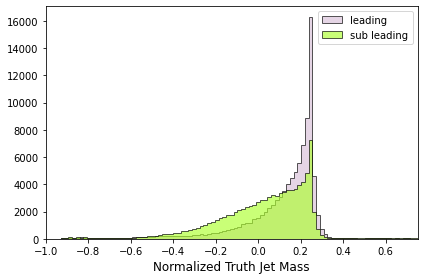

In [24]:
targetn_bins = (target_bins - 1e2) / 1e2 #because of MeV to GeV as above

plt.hist(Yn[:,0], bins=targetn_bins, label='leading', alpha=.65, color='thistle',
        edgecolor='black', histtype='stepfilled')
plt.hist(Yn[:,1], bins=targetn_bins, label='sub leading', alpha=.65,
         color='greenyellow', edgecolor='black', histtype='stepfilled')
plt.xlim(np.min(targetn_bins), np.max(targetn_bins))
plt.xlabel('Normalized Truth Jet Mass', fontsize=12)
plt.legend()
plt.tight_layout()
# plt.savefig('Plots/Sept22/truthJetMass_normalized.png')
plt.show()

### Inputs

In [25]:
Xsn[:,0] = (X[:,0] - 100) / 1e2
Xsn[:,4] = (X[:,10] - 100) / 1e2

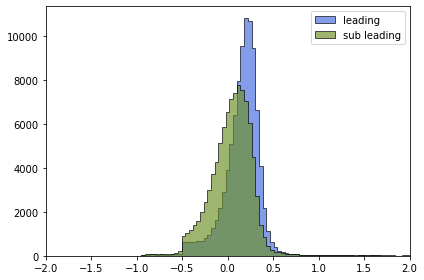

In [26]:
massn_bins = np.linspace(-2,2,100,endpoint=True)

plt.hist(Xsn[:,0], bins=massn_bins, label='leading', alpha=.65, color='royalblue',
        edgecolor='black', histtype='stepfilled')
plt.hist(Xsn[:,4], bins=massn_bins, label='sub leading', alpha=.65,
         color='olivedrab', edgecolor='black', histtype='stepfilled')
plt.xlim(np.min(massn_bins), np.max(massn_bins))
plt.legend()
plt.tight_layout()
# plt.savefig('Plots/Sept22/JetMass_normalized.png')
plt.show()

In [27]:
pt_av = ( np.mean(np.log(X[:,1])) + np.mean(np.log(X[:,11])) ) /2
pt_std = ( np.std(np.log(X[:,1])) + np.std(np.log(X[:,11])) ) /2
print('log pt average: {:8.4f}'.format(pt_av))
print('pt average: {:8.4f} [MeV]'.format(np.exp(pt_av)))
print('log pt_std: {:8.4f}'.format(pt_std))

Xsn[:,1] = (np.log(X[:,1]) - pt_av) / pt_std
Xsn[:,5] = (np.log(X[:,11]) - pt_av) / pt_std

log pt average:   6.2886
pt average: 538.3990 [MeV]
log pt_std:   0.3984


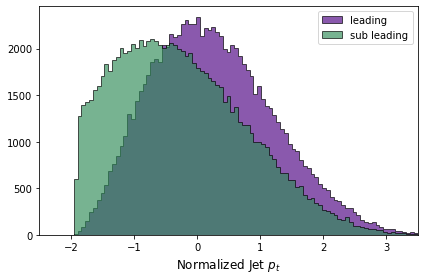

In [28]:
logPtn_bins = np.linspace(-2.5,3.5,100,endpoint=True)

plt.hist(Xsn[:,1], bins=logPtn_bins, label='leading', alpha=.65, color='indigo',
        edgecolor='black', histtype='stepfilled')
plt.hist(Xsn[:,5], bins=logPtn_bins, label='sub leading', alpha=.65,
         color='seagreen', edgecolor='black', histtype='stepfilled')
plt.xlim(np.min(logPtn_bins), np.max(logPtn_bins))
plt.xlabel('Normalized Jet $p_t$', fontsize=12)
plt.legend()
plt.tight_layout()
# plt.savefig('Plots/Sept22/JetPt_normalized.png')
plt.show()

In [29]:
eta_av = ( np.mean(X[:,2]) + np.mean(X[:,12]) ) /2
eta_std = ( np.std(X[:,2]) + np.std(X[:,12]) ) /2
print('eta average: {}'.format(eta_av))
print('eta_std: {}'.format(eta_std))

Xsn[:,2] = X[:,2] / eta_std
Xsn[:,6] = X[:,12] / eta_std

eta average: -0.0009072141019247392
eta_std: 0.8337986058000857


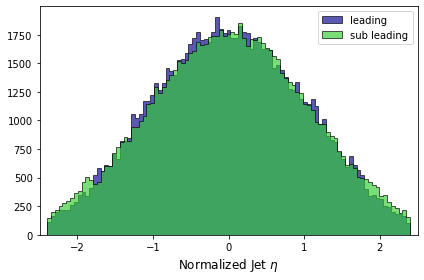

In [30]:
etan_bins = np.linspace(-2.5,2.5,100,endpoint=True)

plt.hist(Xsn[:,2], bins=etan_bins, label='leading', alpha=.65, color='darkblue',
        edgecolor='black', histtype='stepfilled')
plt.hist(Xsn[:,6], bins=etan_bins, label='sub leading', alpha=.65,
         color='limegreen', edgecolor='black', histtype='stepfilled')
plt.xlim(np.min(etan_bins), np.max(etan_bins))
plt.xlabel('Normalized Jet $\eta$', fontsize=12)
plt.legend()
plt.tight_layout()
# plt.savefig('Plots/Sept22/JetEta_normalized.png')
plt.show()

In [31]:
Xsn[:,3] = X[:,3] / 3
Xsn[:,7] = X[:,13] / 3

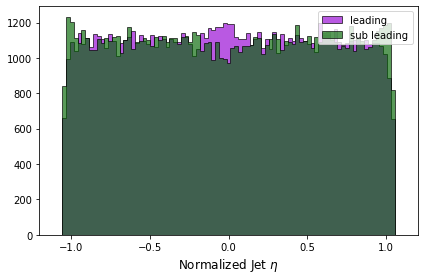

In [32]:
phin_bins = np.linspace(-1.2,1.2,100,endpoint=True)

plt.hist(Xsn[:,3], bins=phin_bins, label='leading', alpha=.65, color='darkviolet',
        edgecolor='black', histtype='stepfilled')
plt.hist(Xsn[:,7], bins=phin_bins, label='sub leading', alpha=.65,
         color='darkgreen', edgecolor='black', histtype='stepfilled')
plt.xlim(np.min(phin_bins), np.max(phin_bins))
plt.xlabel('Normalized Jet $\eta$', fontsize=12)
plt.legend()
plt.tight_layout()
# plt.savefig('Plots/Sept22/JetEta_normalized.png')
plt.show()

## Inspect Jet Substructure Variables

[ 0.   2.5  5.   7.5 10.  12.5 15.  17.5 20.  22.5]


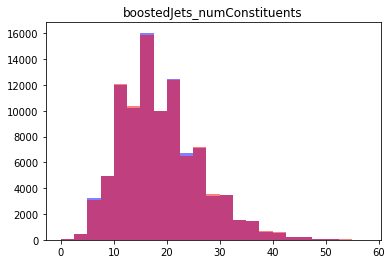

In [33]:
constituent_bins = np.arange(0,60,2.5)
print(constituent_bins[:10])

plt.hist(X[:,4], bins=constituent_bins, color='blue', alpha=.5)
plt.hist(X[:,14], bins=constituent_bins, color='red', alpha=.5)
plt.title('boostedJets_numConstituents')
plt.show()

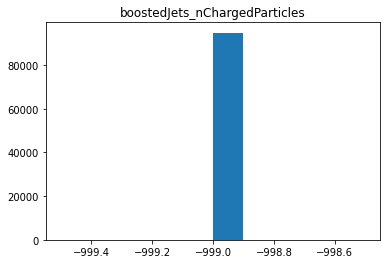

[-999. -999. -999. -999. -999. -999. -999. -999. -999. -999. -999. -999.
 -999. -999. -999. -999. -999. -999. -999. -999.]


In [34]:
plt.hist(X[:,5])
plt.title('boostedJets_nChargedParticles')
plt.show()

print(X[:20,5])

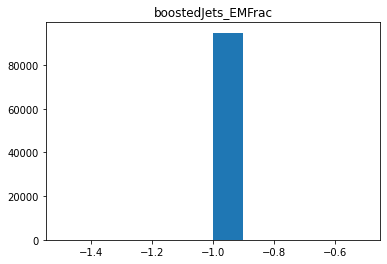

[-1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1.]


In [35]:
plt.hist(X[:,6])
plt.title('boostedJets_EMFrac')
plt.show()

print(X[:20,6])

[ 0.   2.5  5.   7.5 10.  12.5 15.  17.5 20.  22.5 25.  27.5 30.  32.5
 35.  37.5 40.  42.5 45.  47.5 50.  52.5 55.  57.5]


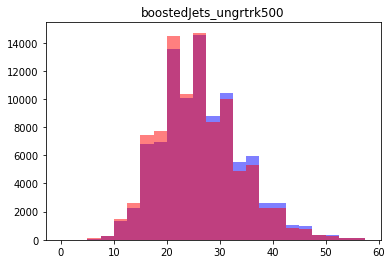

[24. 23. 26. 45. 29. 28. 35. 36. 15. 19. 30. 22. 27. 47. 29. 19. 22. 25.
 31. 27.]


In [36]:
ungtrk_bins=np.arange(0,60,2.5)
print(ungtrk_bins)

plt.hist(X[:,7], bins=ungtrk_bins, color='blue', alpha=.5)
plt.hist(X[:,17], bins=ungtrk_bins, color='red', alpha=.5)
plt.title('boostedJets_ungrtrk500')
plt.show()

print(X[:20,7])

[ 0  5 10 15 20 25 30 35 40 45 50 55 60 65]


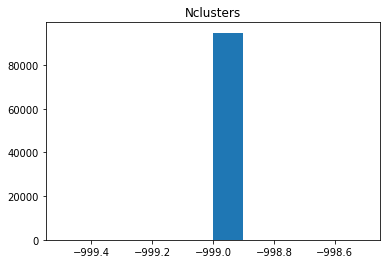

[-999. -999. -999. -999. -999. -999. -999. -999. -999. -999. -999. -999.
 -999. -999. -999. -999. -999. -999. -999. -999.]


In [37]:
cluster_bins=np.arange(0,70,5)
print(cluster_bins)

plt.hist(X[:,8])
plt.title('Nclusters')
plt.show()

print(X[:20,8])

[0.5 1.5 2.5 3.5 4.5 5.5 6.5 7.5 8.5 9.5]


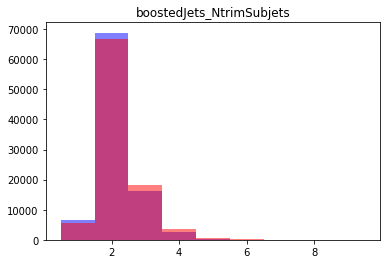

[2. 2. 2. 4. 3. 2. 3. 2. 1. 2. 2. 1. 3. 2. 1. 2. 3. 2. 2. 2.]


In [38]:
subjet_bins=np.arange(.5,10.5,1)
print(subjet_bins)

plt.hist(X[:,9], bins=subjet_bins, color='blue', alpha=.5)
plt.hist(X[:,19], bins=subjet_bins, color='red', alpha=.5)
plt.title('boostedJets_NtrimSubjets')
plt.show()

print(X[:20,9])

# Normalize remainder

In [39]:
# Xln = np.empty((X.shape[0], 14))
# we want to create shallow copies as to conserve memory and not
# have to do normalization calculations twice :)
# Xspl1 = Xln[:,:7]
# Xspl2 = Xln[:,7:14]

#testing shallow copy!
# Xln[0,1] = np.pi
# Xln[0,8] = np.pi
# print(Xspl1.shape)
# print(Xspl2.shape)
# print(Xspl1[0,1])
# print(Xspl2[0,1])

### Baseline Values

In [40]:
Xln = np.empty((X.shape[0], 14))

Xln[:,:4] = np.ndarray.copy(Xsn[:,:4])
Xln[:,7:11] = np.ndarray.copy(Xsn[:,4:8])
print(Xln[:,:4].shape)
print(Xln[:,7:11].shape)

(94859, 4)
(94859, 4)


### boostedJets_numConstituents (X \#4,14)

19



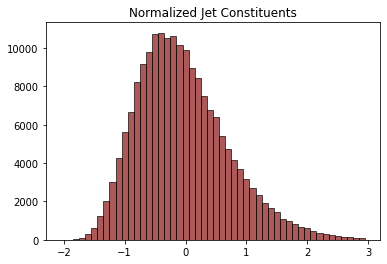

[-2.05 -1.95 -1.85 -1.75 -1.65 -1.55 -1.45 -1.35 -1.25 -1.15 -1.05 -0.95
 -0.85 -0.75 -0.65 -0.55 -0.45 -0.35 -0.25 -0.15 -0.05  0.05  0.15  0.25
  0.35  0.45  0.55  0.65  0.75  0.85  0.95  1.05  1.15  1.25  1.35  1.45
  1.55  1.65  1.75  1.85  1.95  2.05  2.15  2.25  2.35  2.45  2.55  2.65
  2.75  2.85  2.95]
[-0.1 -0.2 -1.   1.3  0.9 -0.8  0.7  0.  -1.  -0.2]


In [41]:
av_nConstituents = int(np.round( np.mean(np.concatenate((X[:,4], X[:,14]), axis=0)) ))
print(av_nConstituents);print()

Xln[:,4] = (X[:,4] - av_nConstituents) /10
Xln[:,11] = (X[:,14] - av_nConstituents) /10

bJet_NCBins = np.arange(-2.05,3.05,.1)
plt.hist(np.concatenate((Xln[:,4], Xln[:,11]), axis=0), color='maroon',
         edgecolor='black', alpha=.65, bins=bJet_NCBins)
plt.title('Normalized Jet Constituents')
plt.show()

print(bJet_NCBins)
print(Xln[:10,4])

### boostedJets_ungrtrk500 (X \#7,17)

26



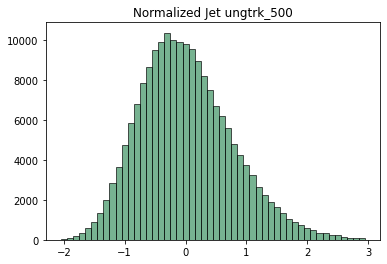

[-2.05 -1.95 -1.85 -1.75 -1.65 -1.55 -1.45 -1.35 -1.25 -1.15 -1.05 -0.95
 -0.85 -0.75 -0.65 -0.55 -0.45 -0.35 -0.25 -0.15 -0.05  0.05  0.15  0.25
  0.35  0.45  0.55  0.65  0.75  0.85  0.95  1.05  1.15  1.25  1.35  1.45
  1.55  1.65  1.75  1.85  1.95  2.05  2.15  2.25  2.35  2.45  2.55  2.65
  2.75  2.85  2.95]
[-0.2 -0.3  0.   1.9  0.3  0.2  0.9  1.  -1.1 -0.7]


In [42]:
av_bJet_ungrtrk500 = int(np.round( np.mean( np.concatenate((X[:,7], X[:,17]), axis=0) ) ))
print(av_bJet_ungrtrk500);print()

Xln[:,5] = (X[:,7] - av_bJet_ungrtrk500) /10
Xln[:,12] = (X[:,17] - av_bJet_ungrtrk500) /10

bJet_ungrtk_bins = np.arange(-2.05,3.05,.1)
plt.hist(np.concatenate((Xln[:,5], Xln[:,12]), axis=0), color='seagreen',
         edgecolor='black', alpha=.65, bins=bJet_ungrtk_bins)
plt.title('Normalized Jet ungtrk_500')
plt.show()

print(bJet_ungrtk_bins)
print(Xln[:10,5])

### boosted_NTrimSubjets

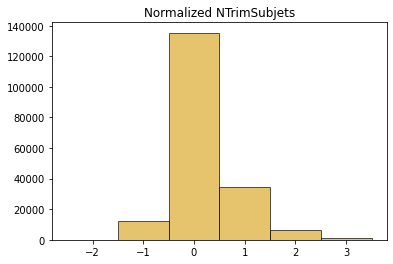

[-2.5 -1.5 -0.5  0.5  1.5  2.5  3.5]
[ 0.  0.  0.  2.  1.  0.  1.  0. -1.  0.]


In [43]:
Xln[:,6] = X[:,9] - 2
Xln[:,13] = X[:,19] - 2

bJet_NTrimSub_bins = np.arange(-2.5,4.0,1.)
plt.hist(np.concatenate((Xln[:,6], Xln[:,13]), axis=0), color='goldenrod',
         edgecolor='black', alpha=.65, bins=bJet_NTrimSub_bins)
plt.title('Normalized NTrimSubjets')
plt.show()

print(bJet_NTrimSub_bins)
print(Xln[:10,6])

## Split Data

In [44]:
Xspl1 = Xln[:,:7]
Xspl2 = Xln[:,7:14]
print(Xspl1.shape)
print(Xspl2.shape)

(94859, 7)
(94859, 7)


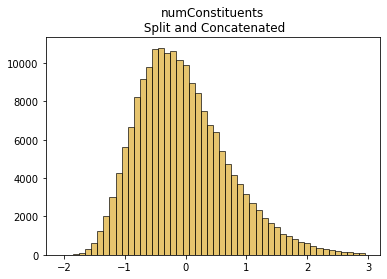

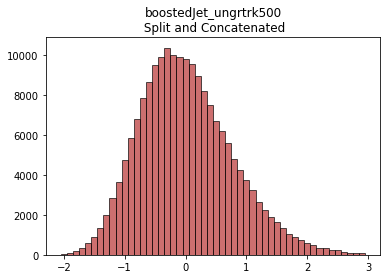

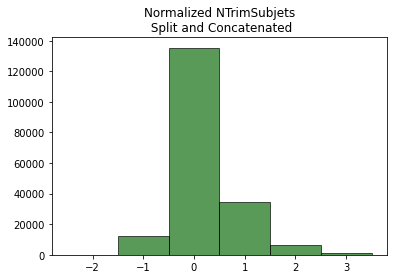

In [45]:
bJet_NCBins = np.arange(-2.05,3.05,.1)
plt.hist(np.concatenate((Xspl1[:,4], Xspl2[:,4]), axis=0), color='goldenrod',
         edgecolor='black', alpha=.65, bins=bJet_NCBins)
plt.title('numConstituents\n Split and Concatenated')
plt.show()

## Boosted Jet ungrtrk500
bJet_ungrtk_bins = np.arange(-2.05,3.05,.1)
plt.hist(np.concatenate((Xspl1[:,5], Xspl2[:,5]), axis=0), color='firebrick',
         edgecolor='black', alpha=.65, bins=bJet_ungrtk_bins)
plt.title('boostedJet_ungrtrk500\n Split and Concatenated')
plt.show()

bJet_NTrimSub_bins = np.arange(-2.5,4.0,1.)
plt.hist(np.concatenate((Xspl1[:,6], Xspl2[:,6]), axis=0), color='darkgreen',
         edgecolor='black', alpha=.65, bins=bJet_NTrimSub_bins)
plt.title('Normalized NTrimSubjets\n Split and Concatenated')
plt.show()

## Split Data for Training

In [46]:
NTrain, NVal, NTest = tvt_num(Yn, (70,15,15))
print(NTrain, NVal, NTest)

66401 14229 14229


In [47]:
## full shapes
print(' -- Full shapes --'); print()
print(' -- Target --')
print(Yn.shape)
NEvt = Yn.shape[0]
print(' -- Small Data --')
print(Xsn.shape)
print(' -- Large Data --')
print(Xln.shape)
print(' -- Split Data --')
print(Xspl1.shape)
print(Xspl2.shape);print()

Xsn_tr = Xsn[:NTrain,:]
Xsn_val = Xsn[NTrain:NVal+NTrain,:]
Xsn_test = Xsn[NVal+NTrain:,:]

Xln_tr = Xln[:NTrain,:]
Xln_val = Xln[NTrain:NVal+NTrain,:]
Xln_test = Xln[NVal+NTrain:,:]

Xspl1_tr = Xspl1[:NTrain,:]
Xspl1_val = Xspl1[NTrain:NVal+NTrain,:]
Xspl1_test = Xspl1[NVal+NTrain:,:]

Xspl2_tr = Xspl2[:NTrain,:]
Xspl2_val = Xspl2[NTrain:NVal+NTrain,:]
Xspl2_test = Xspl2[NVal+NTrain:,:]

Yn_tr = Yn[:NTrain,:]
Yn_val = Yn[NTrain:NVal+NTrain,:]
Yn_test = Yn[NVal+NTrain:,:]

print(' -- Training shapes --');print()
print(' -- X small --')
print(Xsn_tr.shape)
print(Xsn_val.shape)
print(Xsn_test.shape);print()

print(' -- X large --')
print(Xln_tr.shape)
print(Xln_val.shape)
print(Xln_test.shape);print()

print(' -- X split --')
print(Xspl2_tr.shape)
print(Xspl2_val.shape)
print(Xspl2_test.shape)

 -- Full shapes --

 -- Target --
(94859, 2)
 -- Small Data --
(94859, 8)
 -- Large Data --
(94859, 14)
 -- Split Data --
(94859, 7)
(94859, 7)

 -- Training shapes --

 -- X small --
(66401, 8)
(14229, 8)
(14229, 8)

 -- X large --
(66401, 14)
(14229, 14)
(14229, 14)

 -- X split --
(66401, 7)
(14229, 7)
(14229, 7)


## Compile Networks

In [48]:
base_model = Dumb_Network(num_features=8, name='baseline_DNN')
base_model.compile(loss='mse', optimizer=keras.optimizers.Adam(
    learning_rate=.002))
base_model.summary()

Model: "baseline_DNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 8)]               0         
_________________________________________________________________
dense_0 (Dense)              (None, 100)               900       
_________________________________________________________________
activation_0 (Activation)    (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               10100     
_________________________________________________________________
activation_1 (Activation)    (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
activation_2 (Activation)    (None, 100)              

In [49]:
large_model = Dumb_Network(num_features=14, name='larger_DNN')
large_model.compile(loss='mse', optimizer=keras.optimizers.Adam(
    learning_rate=.002))
large_model.summary()

Model: "larger_DNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 14)]              0         
_________________________________________________________________
dense_0 (Dense)              (None, 100)               1500      
_________________________________________________________________
activation_0 (Activation)    (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               10100     
_________________________________________________________________
activation_1 (Activation)    (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
activation_2 (Activation)    (None, 100)               0

In [50]:
dropout_model = DNN_wDropout(num_features=14, name='DNN_wDO')
dropout_model.compile(loss='mse', optimizer=keras.optimizers.Adam(
    learning_rate=.002))
dropout_model.summary()

Model: "DNN_wDO"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 14)]              0         
_________________________________________________________________
dense_0 (Dense)              (None, 100)               1500      
_________________________________________________________________
activation_0 (Activation)    (None, 100)               0         
_________________________________________________________________
dropout_0 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               10100     
_________________________________________________________________
activation_1 (Activation)    (None, 100)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0   

In [51]:
split_model = Split_Network(num_features=14, name='Split_Network')
split_model.compile(loss='mse', optimizer=keras.optimizers.Adam(
    learning_rate=.002))
split_model.summary()

Model: "Split_Network"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Leading Jet Input (InputLayer)  [(None, 7)]          0                                            
__________________________________________________________________________________________________
dense_L0 (Dense)                (None, 100)          800         Leading Jet Input[0][0]          
__________________________________________________________________________________________________
activation_L0 (Activation)      (None, 100)          0           dense_L0[0][0]                   
__________________________________________________________________________________________________
dense_L1 (Dense)                (None, 100)          10100       activation_L0[0][0]              
______________________________________________________________________________________

# Properly Train Network

In [52]:
dnn_history = base_model.fit(
                Xsn_tr,
                Yn_tr,
                validation_data=(Xsn_val, Yn_val),
                shuffle=True,
                epochs=100,
                batch_size=6000)

2022-10-04 06:10:42.028915: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/100
12/12 [==============================] - 1s 19ms/step - loss: 0.0568 - val_loss: 0.0335
Epoch 2/100
12/12 [==============================] - 0s 7ms/step - loss: 0.0260 - val_loss: 0.0223
Epoch 3/100
12/12 [==============================] - 0s 7ms/step - loss: 0.0211 - val_loss: 0.0202
Epoch 4/100
12/12 [==============================] - 0s 7ms/step - loss: 0.0197 - val_loss: 0.0194
Epoch 5/100
12/12 [==============================] - 0s 7ms/step - loss: 0.0192 - val_loss: 0.0191
Epoch 6/100
12/12 [==============================] - 0s 7ms/step - loss: 0.0189 - val_loss: 0.0188
Epoch 7/100
12/12 [==============================] - 0s 7ms/step - loss: 0.0186 - val_loss: 0.0188
Epoch 8/100
12/12 [==============================] - 0s 7ms/step - loss: 0.0185 - val_loss: 0.0186
Epoch 9/100
12/12 [==============================] - 0s 7ms/step - loss: 0.0183 - val_loss: 0.0188
Epoch 10/100
12/12 [==============================] - 0s 7ms/step - loss: 0.0182 - val_loss: 0.0185
Epoch 11

In [53]:
Ldnn_history = large_model.fit(
                Xln_tr,
                Yn_tr,
                validation_data=(Xln_val, Yn_val),
                shuffle=True,
                epochs=100,
                batch_size=6000)

Epoch 1/100
12/12 [==============================] - 1s 17ms/step - loss: 0.0603 - val_loss: 0.0435
Epoch 2/100
12/12 [==============================] - 0s 7ms/step - loss: 0.0347 - val_loss: 0.0264
Epoch 3/100
12/12 [==============================] - 0s 7ms/step - loss: 0.0237 - val_loss: 0.0215
Epoch 4/100
12/12 [==============================] - 0s 7ms/step - loss: 0.0209 - val_loss: 0.0201
Epoch 5/100
12/12 [==============================] - 0s 7ms/step - loss: 0.0197 - val_loss: 0.0194
Epoch 6/100
12/12 [==============================] - 0s 7ms/step - loss: 0.0190 - val_loss: 0.0190
Epoch 7/100
12/12 [==============================] - 0s 7ms/step - loss: 0.0186 - val_loss: 0.0189
Epoch 8/100
12/12 [==============================] - 0s 7ms/step - loss: 0.0184 - val_loss: 0.0190
Epoch 9/100
12/12 [==============================] - 0s 7ms/step - loss: 0.0184 - val_loss: 0.0184
Epoch 10/100
12/12 [==============================] - 0s 7ms/step - loss: 0.0182 - val_loss: 0.0188
Epoch 11

In [54]:
L_DOdnn_history = dropout_model.fit(
                Xln_tr,
                Yn_tr,
                validation_data=(Xln_val, Yn_val),
                shuffle=True,
                epochs=100,
                batch_size=6000)

Epoch 1/100
12/12 [==============================] - 1s 18ms/step - loss: 0.0741 - val_loss: 0.0489
Epoch 2/100
12/12 [==============================] - 0s 8ms/step - loss: 0.0475 - val_loss: 0.0332
Epoch 3/100
12/12 [==============================] - 0s 7ms/step - loss: 0.0356 - val_loss: 0.0248
Epoch 4/100
12/12 [==============================] - 0s 8ms/step - loss: 0.0290 - val_loss: 0.0221
Epoch 5/100
12/12 [==============================] - 0s 8ms/step - loss: 0.0261 - val_loss: 0.0207
Epoch 6/100
12/12 [==============================] - 0s 7ms/step - loss: 0.0243 - val_loss: 0.0196
Epoch 7/100
12/12 [==============================] - 0s 7ms/step - loss: 0.0234 - val_loss: 0.0191
Epoch 8/100
12/12 [==============================] - 0s 7ms/step - loss: 0.0225 - val_loss: 0.0190
Epoch 9/100
12/12 [==============================] - 0s 7ms/step - loss: 0.0218 - val_loss: 0.0184
Epoch 10/100
12/12 [==============================] - 0s 7ms/step - loss: 0.0213 - val_loss: 0.0179
Epoch 11

In [55]:
split_history = split_model.fit(
                [Xspl1_tr, Xspl2_tr],
                Yn_tr,
                validation_data=([Xspl1_val, Xspl2_val], Yn_val),
                shuffle=True,
                epochs=100,
                batch_size=6000)

Epoch 1/100
12/12 [==============================] - 1s 16ms/step - loss: 0.0587 - val_loss: 0.0473
Epoch 2/100
12/12 [==============================] - 0s 8ms/step - loss: 0.0456 - val_loss: 0.0437
Epoch 3/100
12/12 [==============================] - 0s 8ms/step - loss: 0.0439 - val_loss: 0.0433
Epoch 4/100
12/12 [==============================] - 0s 8ms/step - loss: 0.0438 - val_loss: 0.0431
Epoch 5/100
12/12 [==============================] - 0s 9ms/step - loss: 0.0435 - val_loss: 0.0429
Epoch 6/100
12/12 [==============================] - 0s 8ms/step - loss: 0.0433 - val_loss: 0.0430
Epoch 7/100
12/12 [==============================] - 0s 9ms/step - loss: 0.0433 - val_loss: 0.0433
Epoch 8/100
12/12 [==============================] - 0s 9ms/step - loss: 0.0433 - val_loss: 0.0427
Epoch 9/100
12/12 [==============================] - 0s 9ms/step - loss: 0.0432 - val_loss: 0.0427
Epoch 10/100
12/12 [==============================] - 0s 8ms/step - loss: 0.0430 - val_loss: 0.0429
Epoch 11

## Make Dict With Results

In [56]:
history_dict = dict()
history_dict['base'] = dnn_history
history_dict['larger'] = Ldnn_history
history_dict['dropout'] = L_DOdnn_history
history_dict['split'] = split_history

<class 'keras.callbacks.History'>
dict_keys(['loss', 'val_loss'])
Key: base
Color: firebrick
Key: larger
Color: tan
Key: dropout
Color: cadetblue
Key: split
Color: mediumorchid


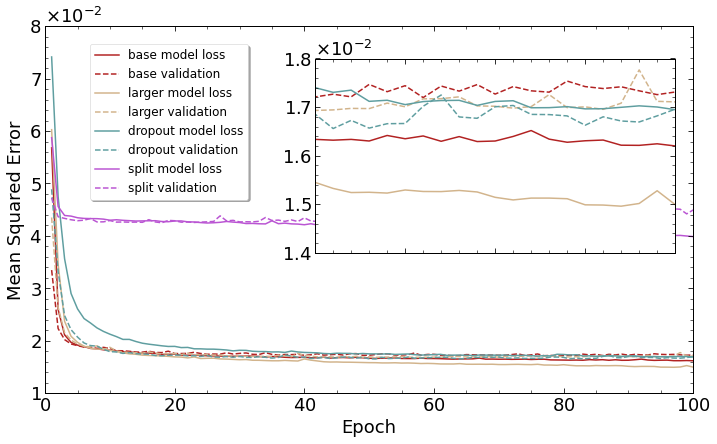

In [133]:
print(type(dnn_history))
print(dnn_history.history.keys())

loss_curve_colors = ['firebrick', 'tan', 'cadetblue', 'mediumorchid']

fig = plt.figure(figsize=(10,6))
dnn_loss = np.array(dnn_history.history['loss'])
dnn_val_loss = np.array(dnn_history.history['val_loss'])
epoch = np.arange(1,len(dnn_loss)+1,1)

ax1 = fig.add_axes([.075,.1,.9,.85])
ax2 = fig.add_axes([.45,.425,.5,.45])

for (color, (key, hist)) in zip(loss_curve_colors, history_dict.items()):
    print('Key: {}'.format(key))
    print('Color: {}'.format(color))
    loss = hist.history['loss']
    val_loss = hist.history['val_loss']    
    ax1.plot(epoch, loss, label='{} model loss'.format(key), ls='solid',
             color=color)
    ax1.plot(epoch, val_loss, label='{} validation'.format(key),
             ls='dashed', color=color)
    ax2.plot(epoch, loss, ls='solid',
             color=color)
    ax2.plot(epoch, val_loss,
             ls='dashed', color=color)

# Axis 1
ax1.set_xlim(0,len(dnn_loss))
ax1.set_xlabel('Epoch', fontsize=18)
ax1.set_ylabel('Mean Squared Error', fontsize=18)

# Axis 2
ax2.set_xlim(80,100)
ax2.set_ylim(.014,.018)
ax2.set_xticklabels([])

# Figure
fig.legend(fontsize=12, loc=[.125,.55], frameon=True, shadow=True, fancybox=True)
fig.savefig('Plots/Oct22/AllNetworks_lossCurves_simple.png', format='png')
fig.show()

### Notes:
 - okay so the network is clearly learning to optimize something here despite minimal information
 - This loss curve suggests we should maybe try dropout?
### Next steps:
 - [x] Split data into training and validation to see where overtraining is happening
 - [x] Add model with dropout
 - [x] Add more jet sub-structure variables
 - [x] Model which handles jets as two different networks
 - [x] Evaluate model with best performing ne-twerk 

## Mass Plane

In [62]:
zeroMask1 = Y[:,0] == 0
print(np.count_nonzero(zeroMask1))

zeroMask2 = Y[:,1] == 0
print(np.count_nonzero(zeroMask2))

print('Conclusion is that neither target mass is zero, so why the error?')

0
0
Conclusion is that neither target mass is zero, so why the error?


# Mass Plane

In [65]:
import atlas_mpl_style as ampl
ampl.use_atlas_style()

## Truth

4293.306640625
847328.375
3245.63671875
624981.8125


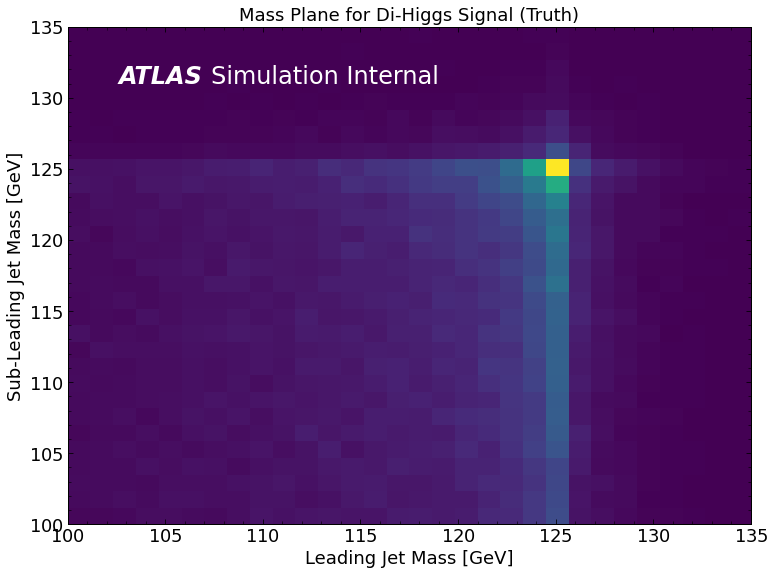

In [106]:
print(np.min(Y[:,0]))
print(np.max(Y[:,0]))
print(np.min(Y[:,1]))
print(np.max(Y[:,1]))

mp_range = [[1e2, 1.35e2], [1e2, 1.35e2]]
try:
    mp1 = Y[:,0]/1000
    mp2 = Y[:,1]/1000
except:
    print('found runtime warning')
    RuntimeWarning

plt.hist2d(x=mp1, y=mp2, bins=30, range=mp_range,
                         density=True, weights=None)
plt.xlabel('Leading Jet Mass [GeV]', fontsize=18)
plt.ylabel('Sub-Leading Jet Mass [GeV]', fontsize=18)
plt.title('Mass Plane for Di-Higgs Signal (Truth)', fontsize=18)
ax_truth = plt.gca()
ampl.plot.draw_atlas_label(x=.075, y=.925, ax=ax_truth, status='int',
                           simulation=True, color='white', fontsize=24)
plt.tight_layout()
# plt.savefig('Plots/Oct22/MassPlane_truth.png')
plt.show()

## Reconstructed

3.098712205886841
848.7841186523438
2.505497455596924
661.237060546875


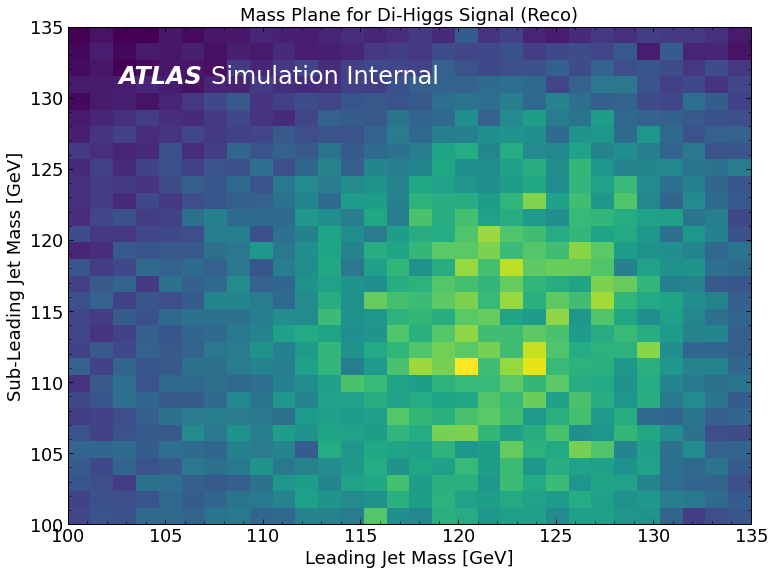

In [105]:
print(np.min(X[:,0]))
print(np.max(X[:,0]))
print(np.min(X[:,10]))
print(np.max(X[:,10]))

mp_range = [[1e2, 1.35e2], [1e2, 1.35e2]]
try:
    mp1r = X[:,0]
    mp2r = X[:,10]
except:
    RuntimeWarning

plt.hist2d(x=mp1r, y=mp2r, bins=30, range=mp_range, 
                         density=True, weights=None)
plt.xlabel('Leading Jet Mass [GeV]', fontsize=18)
plt.ylabel('Sub-Leading Jet Mass [GeV]', fontsize=18)
plt.title('Mass Plane for Di-Higgs Signal (Reco)', fontsize=18)

ax_reco = plt.gca()
ampl.plot.draw_atlas_label(x=.075, y=.925, ax=ax_reco, status='int',
                           simulation=True, color='white', fontsize=24)
plt.tight_layout()
# plt.savefig('Plots/Oct22/MassPlane_reco.png')
plt.show()

## Predictions

In [81]:
print(type(Xln_test))

<class 'numpy.ndarray'>


In [83]:
'''
Ldnn_history = large_model.fit(
                Xln_tr,
                Yn_tr,
                validation_data=(Xln_val, Yn_val),
                shuffle=True,
                epochs=100,
                batch_size=6000)
'''

best_preds = large_model.predict(
                Xln_test,
                batch_size=6000)
print(best_preds.shape)
print(type(best_preds))

(14229, 2)


### Rebuild mass from normalization

In [85]:
'''
Xsn[:,0] = (X[:,0] - 100) / 1e2
Xsn[:,4] = (X[:,10] - 100) / 1e2
'''
LeadJetMass_NN = 100 * best_preds[:,0] + 100
subLeadJetMass_NN = 100 * best_preds[:,1] + 100

<class 'numpy.ndarray'>


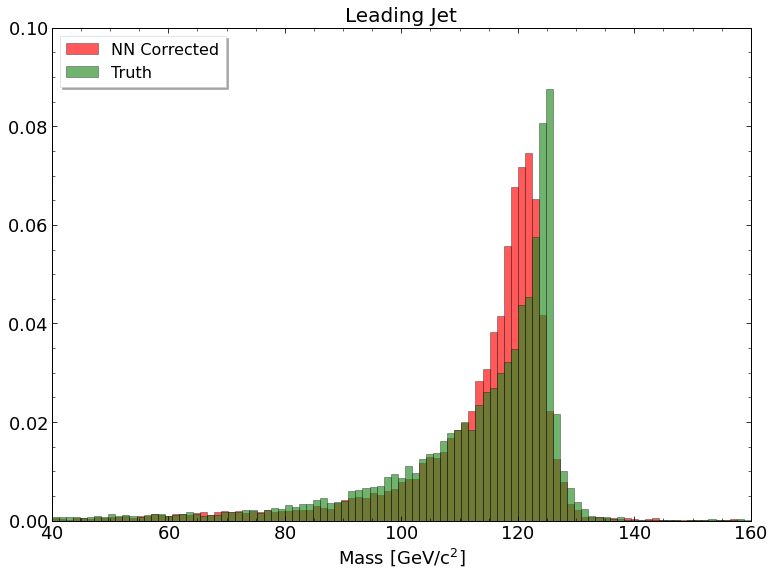

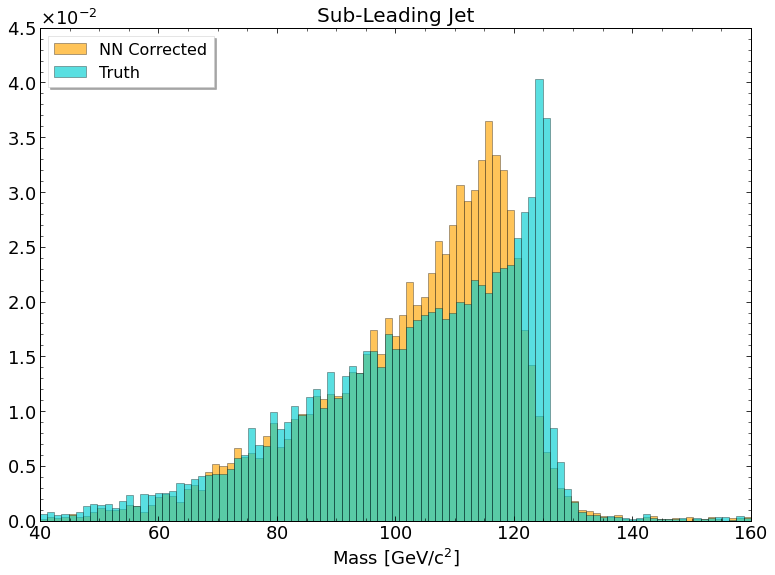

In [103]:
'''
target_bins = np.linspace(0,175,100,endpoint=True)

plt.hist(Y[:,0]/1000, bins=target_bins, label='leading', alpha=.65, color='thistle',
        edgecolor='black', histtype='stepfilled')
plt.hist(Y[:,1]/1000, bins=target_bins, label='sub leading', alpha=.65,
         color='greenyellow', edgecolor='black', histtype='stepfilled')
plt.xlim(np.min(target_bins), np.max(target_bins))
plt.legend()
plt.xlabel('Truth Jet Mass $[GeV/c^2]$', fontsize=12)
plt.tight_layout()
# plt.savefig('Plots/Sept22/truthJetMass_unnormalized.png')
plt.show()
'''


NN_mass_bins = np.linspace(40,160,num=100, endpoint=True)

plt.hist(LeadJetMass_NN, bins=NN_mass_bins, density=True, alpha=.65,
         edgecolor='black', color='red', label='NN Corrected')
plt.hist(Y[NVal+NTrain:,0]/1000, bins=NN_mass_bins, density=True, alpha=.65,
         edgecolor='black', color='forestgreen', label='Truth')
plt.legend(loc='upper left', frameon=True, fontsize=16, shadow=True)
plt.xlim(min(NN_mass_bins), max(NN_mass_bins))
plt.title('Leading Jet', fontsize=20)
plt.xlabel('Mass [$GeV/c^2$]', fontsize=18)
plt.tight_layout()
# plt.savefig('Plots/Oct22/Large_DNN_predictions_leading_jet.png')
plt.show()

NN_mass_bins = np.linspace(40,160,num=100, endpoint=True)

plt.hist(subLeadJetMass_NN, bins=NN_mass_bins, density=True, alpha=.65,
         edgecolor='black', color='orange', label='NN Corrected')
plt.hist(Y[NVal+NTrain:,1]/1000, bins=NN_mass_bins, density=True, alpha=.65,
         edgecolor='black', color='darkturquoise', label='Truth')
plt.legend(loc='upper left', frameon=True, fontsize=16, shadow=True)
plt.xlim(min(NN_mass_bins), max(NN_mass_bins))
plt.title('Sub-Leading Jet', fontsize=20)
plt.xlabel('Mass [$GeV/c^2$]', fontsize=18)
plt.tight_layout()
# plt.savefig('Plots/Oct22/Large_DNN_predictions_subleading_jet.png')
plt.show()

### Mass Plane

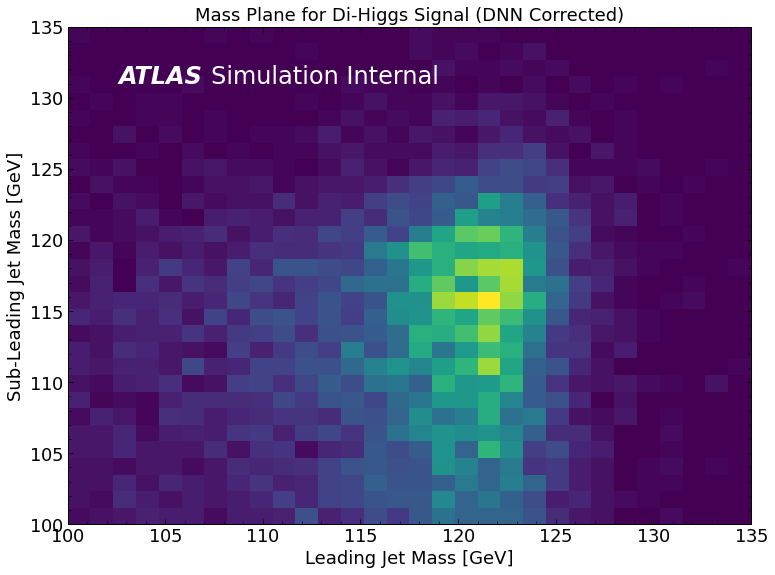

In [104]:
plt.hist2d(x=LeadJetMass_NN, y=subLeadJetMass_NN, bins=30, range=mp_range, 
                         density=True, weights=None)
plt.xlabel('Leading Jet Mass [GeV]', fontsize=18)
plt.ylabel('Sub-Leading Jet Mass [GeV]', fontsize=18)
plt.title('Mass Plane for Di-Higgs Signal (DNN Corrected)', fontsize=18)

ax_reco = plt.gca()
ampl.plot.draw_atlas_label(x=.075, y=.925, ax=ax_reco, status='int',
                           simulation=True, color='white', fontsize=24)
plt.tight_layout()
# plt.savefig('Plots/Oct22/MassPlane_NN_corrected.png')
plt.show()